In [8]:
import sqlite3
import jax.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [9]:
db = sqlite3.connect('backset.db')
cursor = db.cursor()

### Generate Generalized Ratio Dataset By Year

In [10]:
sr_y = {}
get_spend_ratio = lambda row, sr: (sr + (row[2] / row[4])) / 2
get_em_pp = lambda row, em: (em + (row[3] / row[5])) / 2
for i in range(2020, 2024):
    cursor.execute('SELECT * FROM fullpull WHERE year = ?', (i,))
    rows = cursor.fetchall()
    av_spend_ratio = 0.001
    av_em_pp = 0.001
    for row in rows:
        av_spend_ratio = get_spend_ratio(row, av_spend_ratio)
        av_em_pp = get_em_pp(row, av_em_pp)
    sr_y[i] = (av_spend_ratio, av_em_pp)
for item in sr_y:
    sr_y[item] = (sr_y[item][0] * 100, sr_y[item][1])
[print(sr_y[x]) for x in sr_y]

# del sr_y[2021]

(2.398422591443782e-07, 0.0008669471608610203)
(5.473226172354367e-07, 0.000858091691809782)
(9.027485186030562e-07, 0.0005645226193584567)
(7.755002520713168e-07, 0.0005670295165922514)


[None, None, None, None]

### Calculate $R$, $m$, $b$, and the Quartiles for both $x$ and $y$

In [11]:
x_a = np.array([sr_y[year][1] for year in sr_y.keys()])
y_a = np.array([sr_y[year][0] for year in sr_y.keys()])
xq3 = np.percentile(x_a, 75)
yq3 = np.percentile(y_a, 75)
xq1 = np.percentile(x_a, 25)
yq1 = np.percentile(y_a, 25)
slope, intercept = np.polyfit(x_a, y_a, 1)
# Calculate R-squared value
r_value, p_value = stats.pearsonr(x_a, y_a)
print(f"R value: {r_value}")
print(f"Linear regression slope: {slope}, intercept: {intercept}")

R value: -0.8942133188247681
Linear regression slope: -0.0015179809415712953, intercept: 1.7004158507916145e-06


### Plot Dataset with Calculated L.O.B.F.

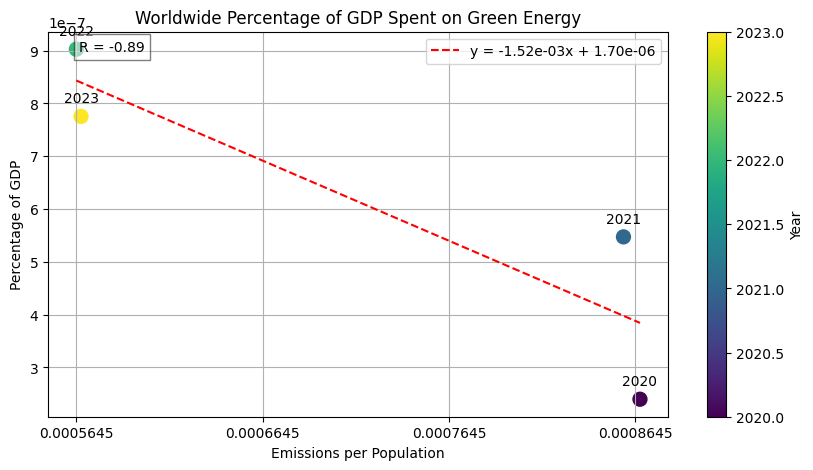

In [12]:
plt.figure(figsize=(10, 5))
plt.title('Worldwide Percentage of GDP Spent on Green Energy')
plt.xlabel('Emissions per Population')
plt.ylabel('Percentage of GDP')

# Create scatter plot with proper ColorMap reference
scatter = plt.scatter([sr_y[year][1] for year in sr_y.keys()], 
                      [sr_y[year][0] for year in sr_y.keys()], 
                      c=list(sr_y.keys()), 
                      cmap='viridis', 
                      s=100)

# Add year annotations
for year in sr_y.keys():
    plt.annotate(str(year), (sr_y[year][1], sr_y[year][0]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

# Set x-ticks for years
plt.xticks(np.arange(min(sr_y.values(), key=lambda x: x[1])[1], 
                     max(sr_y.values(), key=lambda x: x[1])[1], 0.0001))

# Add colorbar using the scatter object as reference
cbar = plt.colorbar(scatter, label='Year')
# Add regression line
x_range = np.linspace(min(x_a), max(x_a), 100)
y_range = slope * x_range + intercept
plt.plot(x_range, y_range, 'r--', label=f'y = {slope:.2e}x + {intercept:.2e}')
# Add R-squared value to plot
plt.text(0.05, 0.95, f'R = {r_value:.2f}', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))

# Add legend
plt.legend()

plt.grid()
plt.show()

### Same as above in 3D Without L.O.B.F.

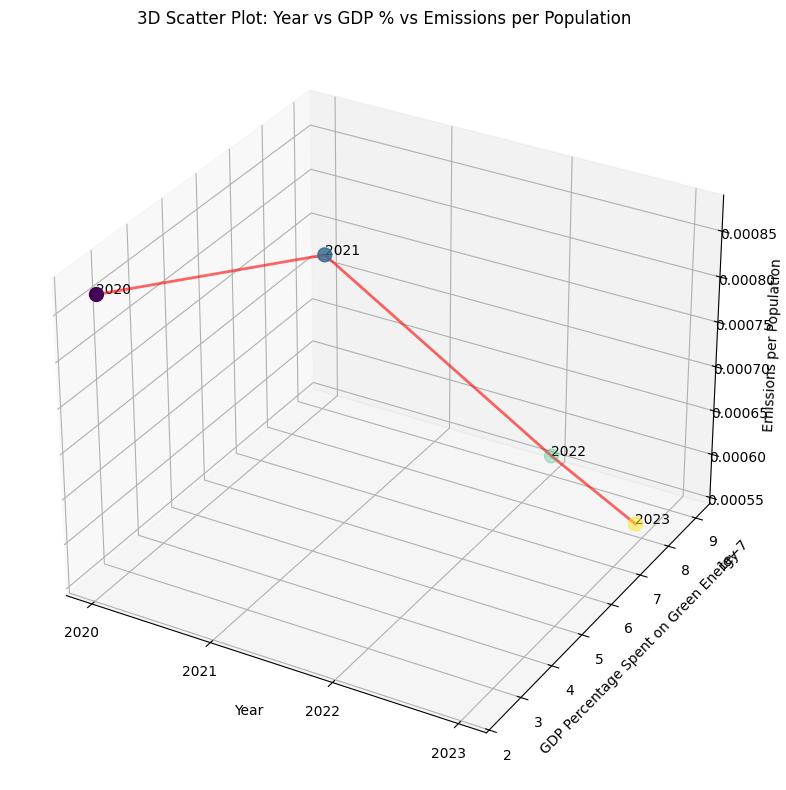

In [13]:
# Extract data for the plot
years = list(sr_y.keys())
gdp_pcts = [sr_y[year][0] for year in years]
em_pp_vals = [sr_y[year][1] for year in years]

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points
sc = ax.scatter(years, gdp_pcts, em_pp_vals, c=years, cmap='viridis', s=100, marker='o')

# Add a line connecting the points
ax.plot(years, gdp_pcts, em_pp_vals, 'r-', linewidth=2, alpha=0.6)

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('GDP Percentage Spent on Green Energy')
ax.set_zlabel('Emissions per Population')
ax.set_title('3D Scatter Plot: Year vs GDP % vs Emissions per Population')

# Set specific ticks for the years
ax.set_xticks(years)

# Add text labels to each point
for year, gdp, em in zip(years, gdp_pcts, em_pp_vals):
    ax.text(year, gdp, em, f'{year}', size=10, zorder=1)

plt.tight_layout()
plt.show()

### Plot all Data with By-Country Granularity

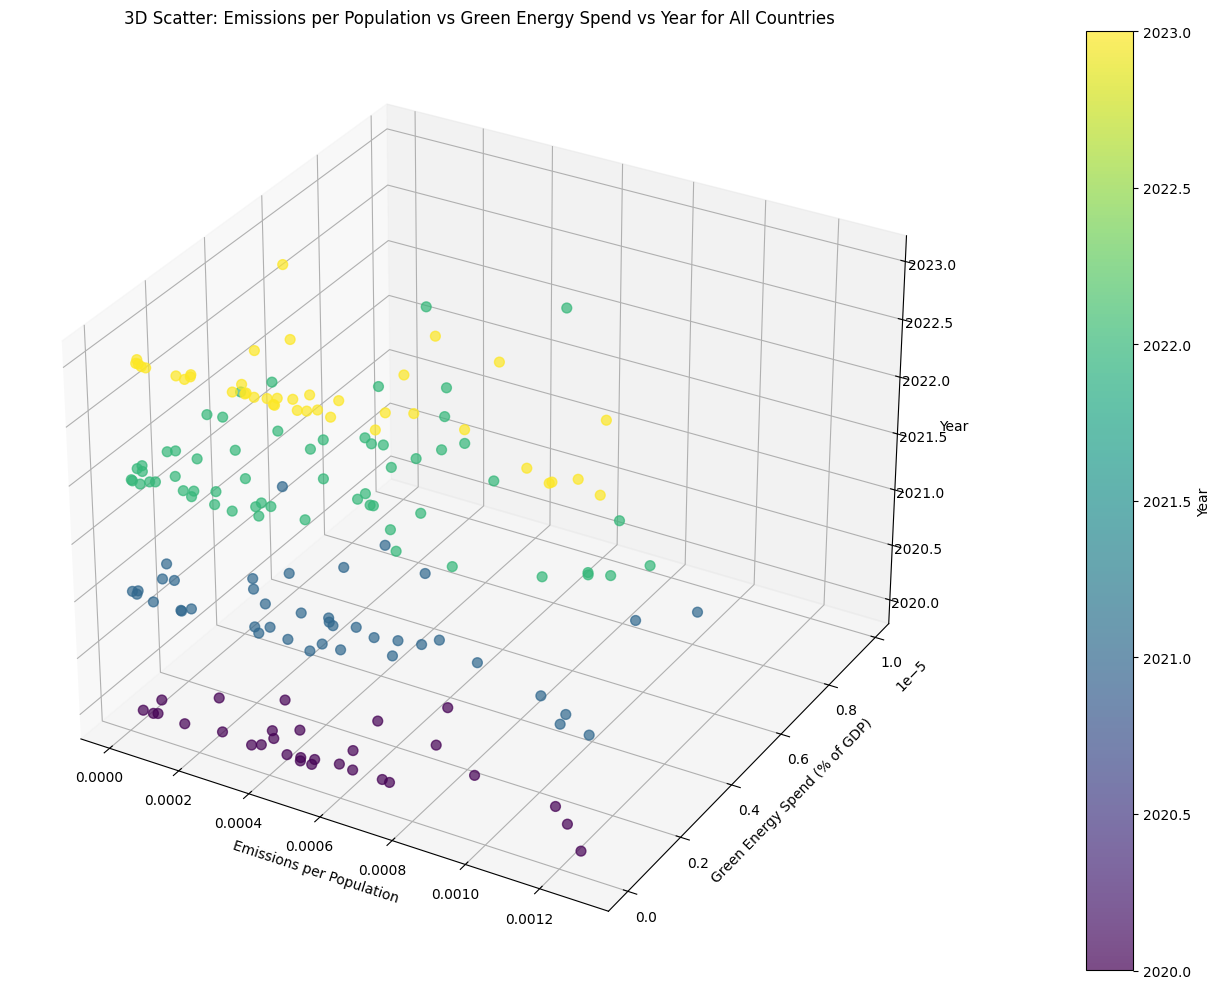

In [14]:
# Create a 3D scatter plot of all countries data
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Get all country data from the database
cursor.execute('SELECT country, year, spending, emissions, gdp, population FROM fullpull')
all_data = cursor.fetchall()

# Calculate ratios for each country
countries = []
years_data = []
spend_gdp_ratios = []
emission_pop_ratios = []

for row in all_data:
    country, year, spend, emissions, gdp, population = row
    if gdp and population:  # Avoid division by zero
        spend_gdp_ratio = spend / gdp * 100  # As percentage
        emission_pop_ratio = emissions / population
        
        countries.append(country)
        years_data.append(int(year))
        spend_gdp_ratios.append(spend_gdp_ratio)
        emission_pop_ratios.append(emission_pop_ratio)

# Create scatter plot with color mapped to year
scatter = ax.scatter(
    emission_pop_ratios, 
    spend_gdp_ratios, 
    years_data, 
    c=years_data, 
    cmap='viridis',
    s=50,
    alpha=0.7
)

# Add labels and title
ax.set_xlabel('Emissions per Population')
ax.set_ylabel('Green Energy Spend (% of GDP)')
ax.set_zlabel('Year')
ax.set_title('3D Scatter: Emissions per Population vs Green Energy Spend vs Year for All Countries')

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Year')

# Optionally, highlight specific countries or add annotations for a subset of points
# This is a randomly selected subset to avoid cluttering the plot
if True == False:
    for i in range(0, len(countries), 20):
        ax.text(
            emission_pop_ratios[i], 
            spend_gdp_ratios[i], 
            years_data[i], 
            countries[i],
            size=8
        )

plt.tight_layout()
plt.show()